In [1]:
#import statements
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#from keypass import NOAA_api
import pylab as pl
from IPython import display

from functools import partial
import pyproj
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

### $TCO_2$ will be target value of final model. The goal of the ML model will be to fill gaps in the dataset in which the target value is missing (~60% of rows). 

First, the gaps in the input variables for the model were filled. The variables missing >5% of rows [gamma, oxygen, apparent O2 utilization, nitrate, silicate, phosphate, total alkilinity, pH] were filled with individual random forest models. 

Startby loading the filled and filtered dataset.


In [3]:
df = pd.read_csv('C:\\Users\\ossan\\DATA606\\DATA\\filledNArows.csv',index_col=0) #save metrics 
print(len(df))

1218966


C:\Users\ossan\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
print(df.columns) 
### we have filled all the nas of the input variables 
print(round(df.isna().sum()/len(df)*100,2))

Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3', 'gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate',
       'phosphate', 'talk', 'phts25p0', 'phtsinsitutp', 'tco2'],
      dtype='object')
cruise           0.00
station          0.00
cast             0.00
year             0.00
month            0.00
day              0.00
latitude         0.00
longitude        0.00
bottomdepth      0.00
maxsampdepth     0.00
pressure         0.00
depth            0.00
temperature      0.00
theta            0.00
salinity         0.00
sigma0           0.00
sigma1           0.00
sigma2           0.00
sigma3           0.00
gamma            0.00
oxygen           0.00
aou              0.00
nitrate          0.00
nitrite          0.00
silicate         0.00
phosphate        0.00
talk             0.00
phts25p0         0.00
pht

### Make a train test validation dataset for the tco2 model. Shuffle the dataset. 

In [4]:
df_emptyCO2 = df[pd.isnull(df).any(axis=1)]
dfCO2 =df.dropna()
dfCO2 = shuffle(dfCO2, random_state=1)
print('rows for co2 training ',len(dfCO2))
print('rows with empty co2 values ',len(df_emptyCO2))

rows for co2 training  434461
rows with empty co2 values  784505


In [5]:
ratio = [.6,.2,.2]
#split to train, test validation sets 
train = dfCO2.iloc[0:int(ratio[0]*dfCO2.shape[0])]
test = dfCO2.iloc[int(ratio[0]*dfCO2.shape[0]):int((ratio[1]+ratio[0])*dfCO2.shape[0])]
validation = dfCO2.iloc[int((ratio[1]+ratio[0])*dfCO2.shape[0]):(dfCO2.shape[0])]
print('Total rows ' + str(dfCO2.shape[0]) +" training "+str(len(train))+ 
      " test " + str(len(test))+ " validation " +str(len(validation)))

Total rows 434461 training 260676 test 86892 validation 86893


### Train, test validate random forest, decision tree, and linear regression. Save metrics to decided on a model for optimization. 

In [ ]:
#This function takes the data split input and trains and tests the dataset per column to 
#find metrics for decision tree (DT), linear regression (LR), and 
#random forest (RF) and return the R2, MSE, and explained variance (EVS) for each 
#column and model type 

def trainAndTest(train,test,c): 
    MSE,R2,EVS,MODEL,COL = [],[],[],[],[]
    DT = DecisionTreeRegressor(); LR = LinearRegression();  RF= RandomForestRegressor()
    #format the splits for multiple input/output regression training 
    inputsTRAIN=train.iloc[:,0:(c-1)];outputsTRAIN=train.loc[:,'tco2']
    inputsTEST=test.iloc[:,0:(c-1)];outputsTEST=test.loc[:,'tco2']
    inputsVAL=validation.iloc[:,0:(c-1)];outputsVAL=validation.loc[:,'tco2']
    for i in range(0,3): 
        MODEL.append('LR');MODEL.append('RF'); MODEL.append('DT')
    for i in range(0,3): COL.append('TRAIN')
    for i in range(0,3): COL.append('TEST')
    for i in range(0,3): COL.append('VAL')
    #fit models 
    LR.fit(inputsTRAIN,outputsTRAIN) 
    RF.fit(inputsTRAIN, outputsTRAIN)
    DT.fit(inputsTRAIN,outputsTRAIN) 
    
    MSE.append(mean_squared_error(outputsTRAIN, LR.predict(inputsTRAIN)))
    R2.append(r2_score(outputsTRAIN, LR.predict(inputsTRAIN)))
    EVS.append(explained_variance_score(outputsTRAIN, LR.predict(inputsTRAIN)))
    MSE.append(mean_squared_error(outputsTRAIN, RF.predict(inputsTRAIN)))
    R2.append(r2_score(outputsTRAIN, RF.predict(inputsTRAIN)))
    EVS.append(explained_variance_score(outputsTRAIN, RF.predict(inputsTRAIN)))
    MSE.append(mean_squared_error(outputsTRAIN, DT.predict(inputsTRAIN)))
    R2.append(r2_score(outputsTRAIN, DT.predict(inputsTRAIN)))
    EVS.append(explained_variance_score(outputsTRAIN, DT.predict(inputsTRAIN)))
    
    MSE.append(mean_squared_error(outputsTEST, LR.predict(inputsTEST)))
    R2.append(r2_score(outputsTEST, LR.predict(inputsTEST)))
    EVS.append(explained_variance_score(outputsTEST, LR.predict(inputsTEST)))
    MSE.append(mean_squared_error(outputsTEST, RF.predict(inputsTEST)))
    R2.append(r2_score(outputsTEST, RF.predict(inputsTEST)))
    EVS.append(explained_variance_score(outputsTEST, RF.predict(inputsTEST)))
    MSE.append(mean_squared_error(outputsTEST, DT.predict(inputsTEST)))
    R2.append(r2_score(outputsTEST, DT.predict(inputsTEST)))
    EVS.append(explained_variance_score(outputsTEST, DT.predict(inputsTEST)))
    
    MSE.append(mean_squared_error(outputsVAL, LR.predict(inputsVAL)))
    R2.append(r2_score(outputsVAL, LR.predict(inputsVAL)))
    EVS.append(explained_variance_score(outputsVAL, LR.predict(inputsVAL)))
    MSE.append(mean_squared_error(outputsVAL, RF.predict(inputsVAL)))
    R2.append(r2_score(outputsVAL, RF.predict(inputsVAL)))
    EVS.append(explained_variance_score(outputsVAL, RF.predict(inputsVAL)))
    MSE.append(mean_squared_error(outputsVAL, DT.predict(inputsVAL)))
    R2.append(r2_score(outputsVAL, DT.predict(inputsVAL)))
    EVS.append(explained_variance_score(outputsVAL, DT.predict(inputsVAL)))

    return pd.DataFrame(list(zip(MODEL,COL,MSE,R2,EVS)),columns=['Model','Set','MSE','R2','EVS'])

traintest=trainAndTest(train,test,30) 
traintest.to_csv('C:\\Users\\ossan\\DATA606\\DATA\\CO2_ML_screen.csv') #save metrics 
traintest

In [106]:
traintest.sort_values(by=['R2'],ascending=False)

,Model,Set,MSE,R2,EVS
2,DT,TRAIN,0.000048,1.000000,1.000000
1,RF,TRAIN,9.843558,0.999160,0.999160
7,RF,VAL,68.706188,0.994179,0.994179
4,RF,TEST,76.959294,0.993455,0.993455
8,DT,VAL,154.338437,0.986924,0.986924
5,DT,TEST,166.839599,0.985812,0.985812
6,LR,VAL,184.831512,0.984341,0.984341
3,LR,TEST,203.481061,0.982696,0.982697
0,LR,TRAIN,209.001695,0.982164,0.982164


### Random forest is the best performing model (R2= .99 on test and validation sets). 

Train with cross validation and save. 

In [18]:
RF= RandomForestRegressor()
inputsTRAIN=train.iloc[:,0:((len(train.columns))-1)];outputsTRAIN=train.loc[:,'tco2']
inputsTEST=test.iloc[:,0:((len(train.columns))-1)];outputsTEST=test.loc[:,'tco2']
inputsVAL=validation.iloc[:,0:((len(train.columns))-1)];outputsVAL=validation.loc[:,'tco2']


In [111]:
# evaluate multioutput regression model with k-fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
n_scores = cross_val_score(RF, inputsTEST,outputsTEST, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)

print('Mean Absolute Error : %.3f Std Deviation (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Absolute Error : 4.387 Std Deviation (0.065)


In [19]:
RF.fit(inputsTRAIN,outputsTRAIN)
trainResults= RF.predict(inputsTRAIN)
testResults = RF.predict(inputsTEST)
valResults = RF.predict(inputsVAL)

In [10]:
feature = pd.DataFrame(list(zip(RF.feature_importances_,inputsTEST.columns)),columns=['Importance','Column'])
feature

,Importance,Column
0,0.001101,cruise
1,0.000550,station
2,0.000102,cast
3,0.001766,year
4,0.000174,month
5,0.000202,day
6,0.001458,latitude
7,0.000796,longitude
8,0.000476,bottomdepth
9,0.000528,maxsampdepth


### Visualize feature importance and ML model performance

https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

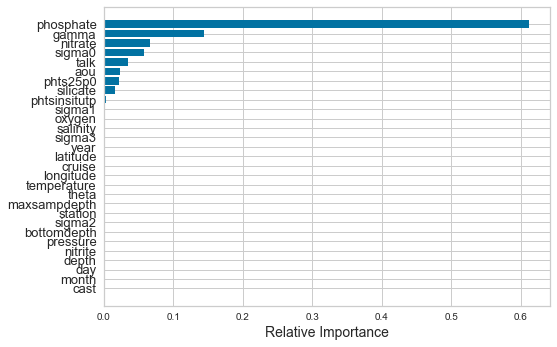

In [123]:
importances = RF.feature_importances_
indices = np.argsort(importances)
features = X.columns

plt.barh(range(len(features)), importances[indices], color='b', align='center')
plt.yticks(range(len(features)), [features[i] for i in indices],fontsize=13)
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

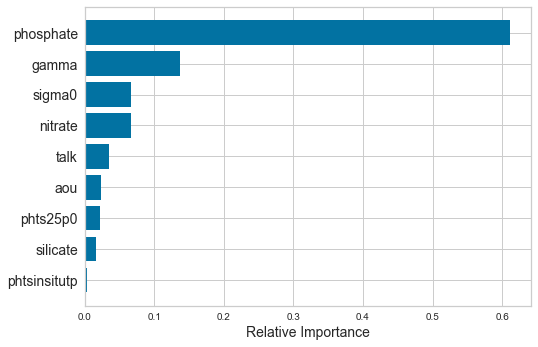

In [111]:
#plt.title('Feature Importances',fontweight = 'bold')
plt.barh(range(9), importances[indices][20:29], color='b', align='center')
plt.yticks(range(9), [features[i] for i in indices[20:29]],fontsize=14)
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

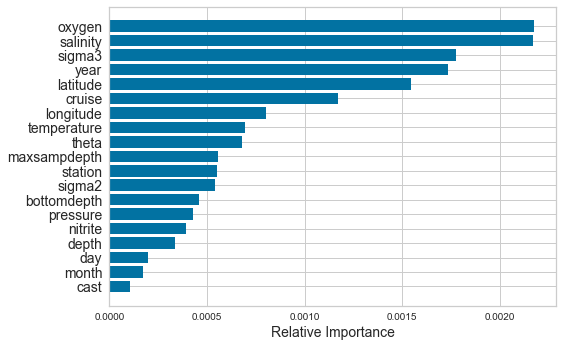

In [120]:

plt.barh(range(19), importances[indices][0:19], color='b', align='center')
plt.yticks(range(19), [features[i] for i in indices[0:19]],fontsize=14)
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [25]:
testResults

array([2323.361, 2304.979, 2046.094, ..., 2253.795, 2165.653, 2162.805])

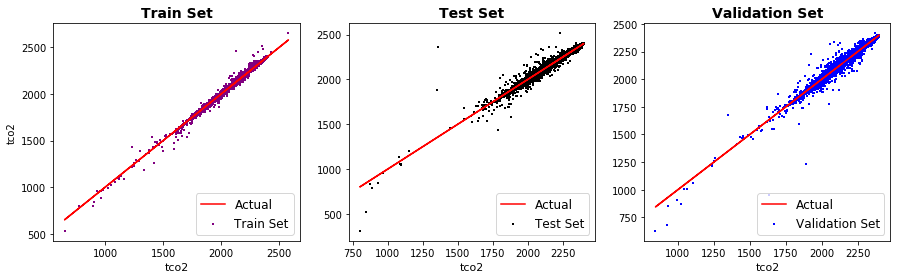

In [30]:

fig, ax= plt.subplots(1,3,figsize=(15,4))
y = 18; modelLabel = 'Decision Tree'

ax[1].scatter(testResults,outputsTEST,color='black',label='Test Set',s=3,marker='+')
ax[1].plot(testResults,testResults,color='red',label='Actual')
ax[0].scatter(trainResults,outputsTRAIN,color='purple',label='Train Set',s=3,marker='+')
ax[0].plot(trainResults,trainResults,color='red',label='Actual')
ax[2].scatter(valResults,outputsVAL,color='blue',label='Validation Set',s=3,marker='+')
ax[2].plot(valResults,valResults,color='red',label='Actual')
ax[1].set_title('Test Set',fontsize=14,fontweight ='bold');ax[0].set_title('Train Set',fontsize=14,fontweight ='bold')
ax[2].set_title('Validation Set',fontsize=14,fontweight ='bold')
ax[0].set_ylabel('tco2')
for x in range(0,3):
    ax[x].legend(fontsize=12,loc='lower right')
    ax[x].set_xlabel('tco2',fontsize=11)

In [124]:

filename = 'C:\\Users\\ossan\\DATA606\\MODELS\\CO2_RF.sav'
pickle.dump(RF, open(filename, 'wb'))

### I want to know if phosphate/other variables feature importance changes when using the original dataset wihtout any filled NA rows. The RF model is trained with this data.

In [21]:
df1= pd.read_csv('C:\\Users\\ossan\\DATA606\\DATA\\cleanedFINAL.csv')
d = ['minute','hour','Date','depthBinned','Ocean Region','fco2temp',
            'pcfc11','cfc11','cfc11','cfc12','pcfc12','pcfc113','pccl4','psf6','bottle']
#shuffle data, replace NAN
s = shuffle(df1.drop(columns=d),random_state = 1)
s=s.replace(-9999.0,np.nan)
s = s.dropna()

In [22]:
reorder=['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3', 'gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate',
       'phosphate',  'talk', 'phts25p0', 'phtsinsitutp','tco2']

s=s[reorder];ratio = [.6,.2,.2]
#split to train, test validation sets 
train =s.iloc[0:int(ratio[0]*s.shape[0])]
test = s.iloc[int(ratio[0]*s.shape[0]):int((ratio[1]+ratio[0])*s.shape[0])]
validation = s.iloc[int((ratio[1]+ratio[0])*s.shape[0]):(s.shape[0])]
print('Total rows ' + str(s.shape[0]) +" training "+str(len(train))+ 
      " test " + str(len(test))+ " validation " +str(len(validation)))

Total rows 127997 training 76798 test 25599 validation 25600


In [23]:
print(len(shuffled),shuffled.columns)
RF= RandomForestRegressor()
inputsTR=train.iloc[:,0:((len(train.columns))-1)];outputsTRAIN=train.loc[:,'tco2']
inputsTE=test.iloc[:,0:((len(train.columns))-1)];outputsTEST=test.loc[:,'tco2']
inputsV=validation.iloc[:,0:((len(train.columns))-1)];outputsVAL=validation.loc[:,'tco2']

RF.fit(inputsTRAIN,outputsTRAIN)
trainResults= RF.predict(inputsTR)
testResults = RF.predict(inputsTE)
valResults = RF.predict(inputsV)

127997 Index(['cruise', 'station', 'cast', 'year', 'month', 'day', 'latitude',
       'longitude', 'bottomdepth', 'maxsampdepth', 'pressure', 'depth',
       'temperature', 'theta', 'salinity', 'sigma0', 'sigma1', 'sigma2',
       'sigma3', 'gamma', 'oxygen', 'aou', 'nitrate', 'nitrite', 'silicate',
       'phosphate', 'talk', 'phts25p0', 'phtsinsitutp', 'tco2'],
      dtype='object')


### The feature importances do not exhibit any noticeable change. 

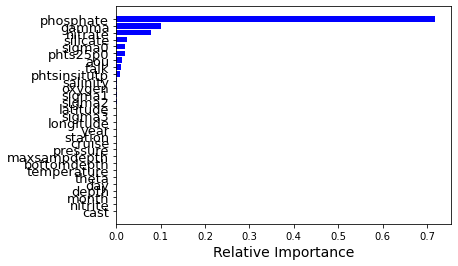

In [25]:
importances = RF.feature_importances_
indices = np.argsort(importances)
features = inputsTEST.columns

plt.barh(range(len(features)), importances[indices], color='b', align='center')
plt.yticks(range(len(features)), [features[i] for i in indices],fontsize=13)
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

### Fill in the tCO2 values with the model. Add a column to mark if they were filled or not. 

In [50]:
filename = 'C:\\Users\\ossan\\DATA606\\MODELS\\CO2_RF.sav'
loaded_RF = pickle.load(open(filename, 'rb'))
#get dataframe to fill 
dfFill = df[df['tco2'].isna()]
#add column markers 
dfFill['Fill']=df['tco2'].isna()
print('rows to fill tco2' ,len(dfFill))

rows to fill tco2 784505


C:\Users\ossan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [73]:
x = len(dfFill.columns)-2
x

a=loaded_RF.predict(dfFill.iloc[:,0:x])
dfFill.tco2 = a
dfFill.tco2

In [86]:
dfFill2 = df[~df['tco2'].isna()]
len(dfFill2)
merged=pd.concat([dfFill2,dfFill])
print('merged length ',len(merged))

merged length  1218966


In [84]:
merged.isna().sum()

cruise          0
station         0
cast            0
year            0
month           0
day             0
latitude        0
longitude       0
bottomdepth     0
maxsampdepth    0
pressure        0
depth           0
temperature     0
theta           0
salinity        0
sigma0          0
sigma1          0
sigma2          0
sigma3          0
gamma           0
oxygen          0
aou             0
nitrate         0
nitrite         0
silicate        0
phosphate       0
talk            0
phts25p0        0
phtsinsitutp    0
tco2            0
Fill            0
dtype: int64

In [87]:
###export for next notebook 
merged.to_csv('C:\\Users\\ossan\\DATA606\\DATA\\TCO2_filled.csv')